# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

# suppress all warnings
import warnings
# warnings.filterwarnings("ignore")

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
!ls arvato_data

Udacity_AZDIAS_052018.csv        Udacity_MAILOUT_052018_TEST.csv
Udacity_CUSTOMERS_052018.csv     Udacity_MAILOUT_052018_TRAIN.csv


### 0.1 Load and explore the data

In [2]:
# load in the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/maiag/opt/anaconda3/envs/uds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# Explore the data

print(azdias.shape)
print(azdias.info())

print(customers.shape)
print(customers.info())

(891221, 366)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None
(191652, 369)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


In [12]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [ ]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [13]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


### 0.2 Check missing values

In [64]:
import seaborn as sns
sns.set_style("darkgrid")

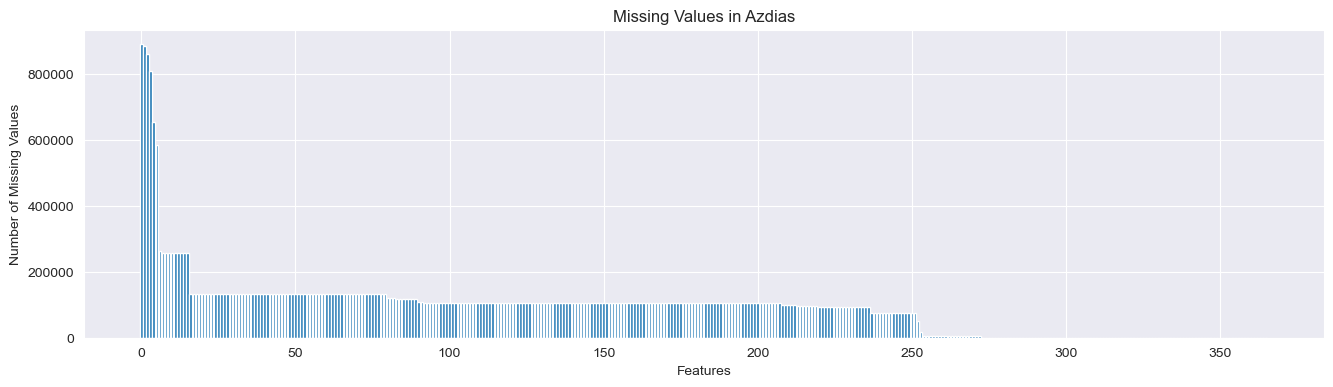

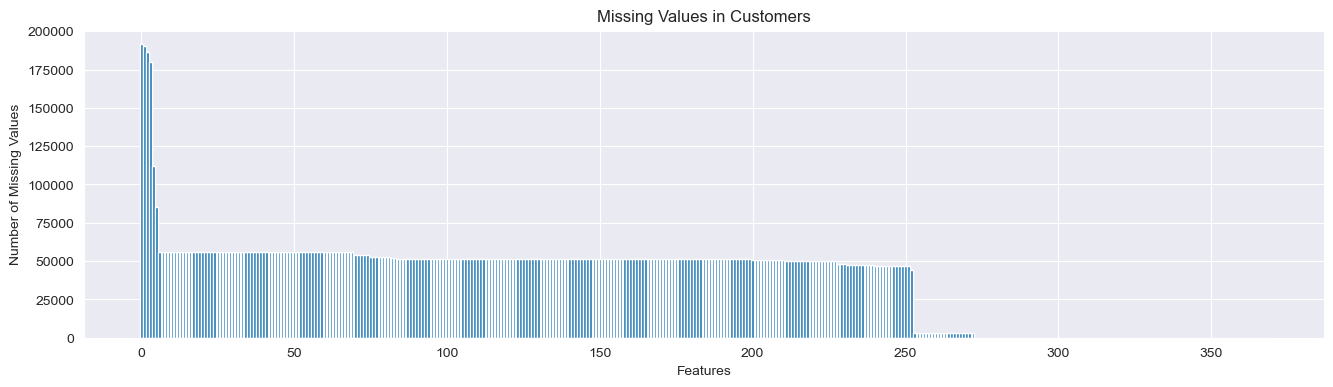

In [ ]:
# Visualize missing value counts
missing_azdias = azdias.isnull().sum().sort_values(ascending=False)
missing_customers = customers.isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(16, 4))
plt.bar(range(len(missing_azdias)), missing_azdias.values)
plt.title("Missing Values in Azdias")
plt.xlabel("Features")
plt.ylabel("Number of Missing Values")
plt.show()

plt.figure(figsize=(16, 4))
plt.bar(range(len(missing_customers)), missing_customers.values)
plt.title("Missing Values in Customers")
plt.xlabel("Features")
plt.ylabel("Number of Missing Values")
plt.show()

[Text(0.0, 0, '0%'),
 Text(0.2, 0, '20%'),
 Text(0.4, 0, '40%'),
 Text(0.6000000000000001, 0, '60%'),
 Text(0.8, 0, '80%'),
 Text(1.0, 0, '100%'),
 Text(1.2000000000000002, 0, '120%')]

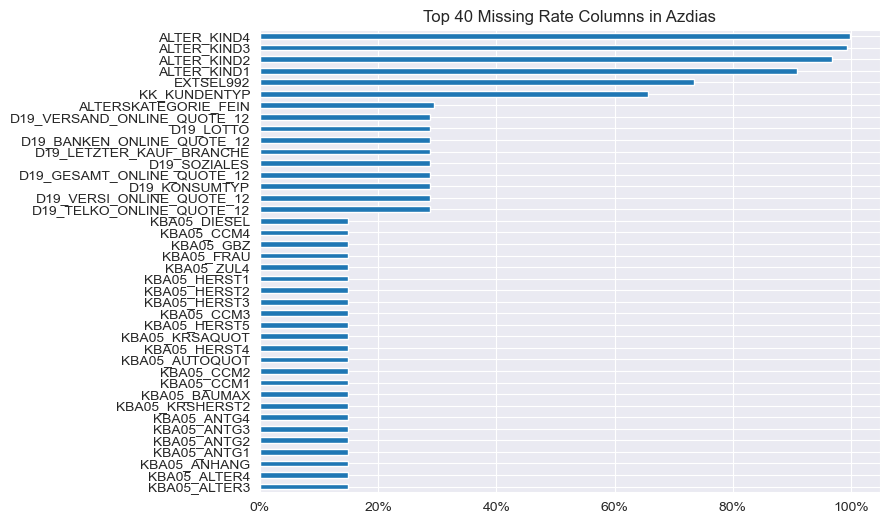

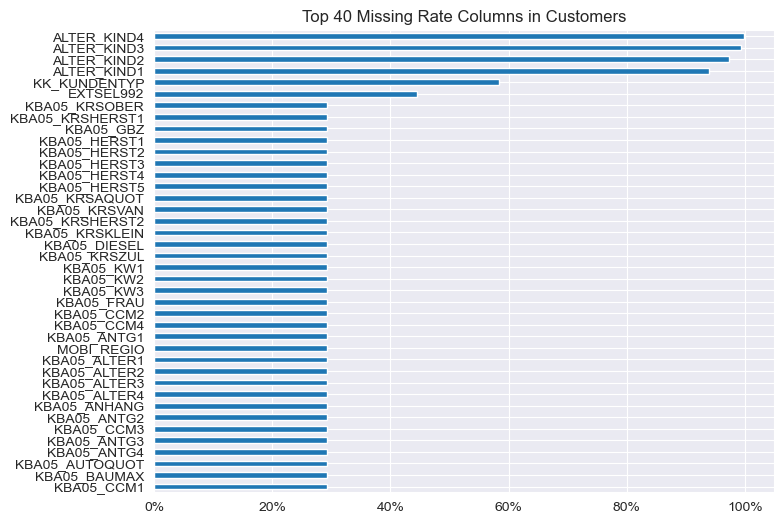

In [127]:
# Visualize top missing rate columns

plt.figure(figsize=(8, 6))
ax = (missing_azdias[:40]/azdias.shape[0]).plot.barh(title='Top 40 Missing Rate Columns in Azdias')
plt.gca().invert_yaxis() # descending rank
vals = ax.get_xticks() 
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]) # x axis % format

plt.figure(figsize=(8, 6))
ax = (missing_customers[:40]/customers.shape[0]).plot.barh(title='Top 40 Missing Rate Columns in Customers')
plt.gca().invert_yaxis() # descending rank
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]) # manipulate x axis format

According to the figures above, the majority of columns have a 20%~30% missing rate, columns with over 30% missing rate may be considered removed. 

Let's check the detailed columns information to decide.

In [10]:
# Load column inforamtion data and ignore any empty columns
no_unamed = lambda x: 'Unnamed' not in x
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, usecols=no_unamed)
attributes_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=no_unamed)

In [11]:
attributes_values["Attribute"] = attributes_values["Attribute"].ffill() # fill attribute name for its value rows
attributes_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [ ]:
attributes_info.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [126]:
# check out the column info of missing percentage > 30%

missing_col_azdias = missing_azdias[missing_azdias/azdias.shape[0]>0.3].index.tolist()
print(missing_col_azdias)
attributes_values[attributes_values["Attribute"].isin(missing_col_azdias)]

['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992', 'KK_KUNDENTYP']


,Attribute,Description,Value,Meaning


In [125]:
missing_customers[missing_customers/customers.shape[0]>0.3].index

Index(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1',
       'KK_KUNDENTYP', 'EXTSEL992'],
      dtype='object')

Columns with over 30% missing rate are the same in the two dataset and they don't have attribute information. 

Therefore, they seem to be unimportant columns and there is no harm to remove them.

### Check warning columns

`DtypeWarning: Columns (18,19) have mixed types.`

In [7]:
warning_cols = list(azdias.columns[18:20])
warning_cols

['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

In [12]:
attributes_values[attributes_values["Attribute"].isin(warning_cols)] # only one found

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


In [13]:
attributes_values[attributes_values["Attribute"].str.contains('INTL_2015')] # try to find another one

,Attribute,Description,Value,Meaning
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,NaN,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,NaN,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,NaN,14,Wealthy Households-Older Families & Mature Co...
110,CAMEO_DEUINTL_2015,NaN,15,Wealthy Households-Elders In Retirement
111,CAMEO_DEUINTL_2015,NaN,21,Prosperous Households-Pre-Family Couples & Sin...
112,CAMEO_DEUINTL_2015,NaN,22,Prosperous Households-Young Couples With Children
113,CAMEO_DEUINTL_2015,NaN,23,Prosperous Households-Families With School Age...
114,CAMEO_DEUINTL_2015,NaN,24,Prosperous Households-Older Families & Mature ...


In [16]:
azdias['CAMEO_DEUG_2015'].unique() # value range match

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [14]:
azdias['CAMEO_INTL_2015'].unique() # value range match

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [15]:
azdias[warning_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  792242 non-null  object
 1   CAMEO_INTL_2015  792242 non-null  object
dtypes: object(2)
memory usage: 13.6+ MB


According to the attribute information above, these two object columns should be categorical values, -1 labels unknown and other numbers label different categories. 

While there's no given information about 'X' and 'XX', so consider them as NaN values and will be automatically conveted as -1.

### Check extra columns

In [ ]:
print("Number of columns in Customers Data - ", len(list(customers.columns)))
print("Number of columns in Azdius Data - ", len(list(azdias.columns)))

extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_cols_in_customers)

Number of columns in Customers Data -  369
Number of columns in Azdius Data -  366
Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [38]:
extra_clm = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers[extra_clm].head()

,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP
0,MULTI_BUYER,0,COSMETIC_AND_FOOD
1,SINGLE_BUYER,0,FOOD
2,MULTI_BUYER,0,COSMETIC_AND_FOOD
3,MULTI_BUYER,0,COSMETIC
4,MULTI_BUYER,0,FOOD


In [131]:
for c in extra_clm:
    print(c, customers[c].unique())

CUSTOMER_GROUP ['MULTI_BUYER' 'SINGLE_BUYER']
ONLINE_PURCHASE [0 1]
PRODUCT_GROUP ['COSMETIC_AND_FOOD' 'FOOD' 'COSMETIC']


In [40]:
customers[extra_clm].isna().sum()

CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
PRODUCT_GROUP      0
dtype: int64

There're 3 extra columns as described. They are clean and don't have missing values.

But need to drop to keep features uniform.

### Preprocessing function

To do data processing based on previous exploration:

- Remove columns with missing value rate > 30%

- Convert object columns (18, 19) to categotical type (Replace 'X', 'XX' values with NaN)

- Fill missing values?

- Drop extra columns

In [21]:
# Preprocessing function
def preprocess_data(df, drop_cols=None, missing_threshold=0.3):
    """
    Preprocess the input DataFrame.

    :param df: Input DataFrame
    :param drop_cols: Columns to drop from the DataFrame (optional)
    :param missing_threshold: Threshold for the proportion of missing values to drop a column
    :return: Preprocessed DataFrame
    """
    # Drop columns with a high proportion of missing values
    missing_proportions = df.isnull().sum() / len(df)
    cols_to_drop = missing_proportions[missing_proportions > missing_threshold].index
    df = df.drop(cols_to_drop, axis=1)

    # Drop unnecessary columns
    if drop_cols:
        df = df.drop(drop_cols, axis=1)

    # Fill missing values with the mode of the respective columns
    # for col in df.columns:
    #     df[col].fillna(df[col].mode()[0], inplace=True)

    # Convert object columns to categorical
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category').cat.codes

    return df

# Apply the preprocessing function to the data
azdias_clean = preprocess_data(azdias, drop_cols=None)
customers_clean = preprocess_data(customers, drop_cols=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

In [22]:
azdias_clean['CAMEO_INTL_2015'].unique() # 'X', 'XX', NaN --> -1

array([-1, 17,  6,  0, 14, 19,  4,  2,  1,  3, 10, 13, 11, 20,  7,  5,  8,
       18, 12, 16, 15,  9, 25, 27, 34, 21, 40, 38, 36, 33, 26, 28, 23, 32,
       39, 41, 29, 30, 24, 22, 35, 31, 37, 42], dtype=int8)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the general population data and transform both datasets
azdias_scaled = scaler.fit_transform(azdias_clean)
customers_scaled = scaler.transform(customers_clean)

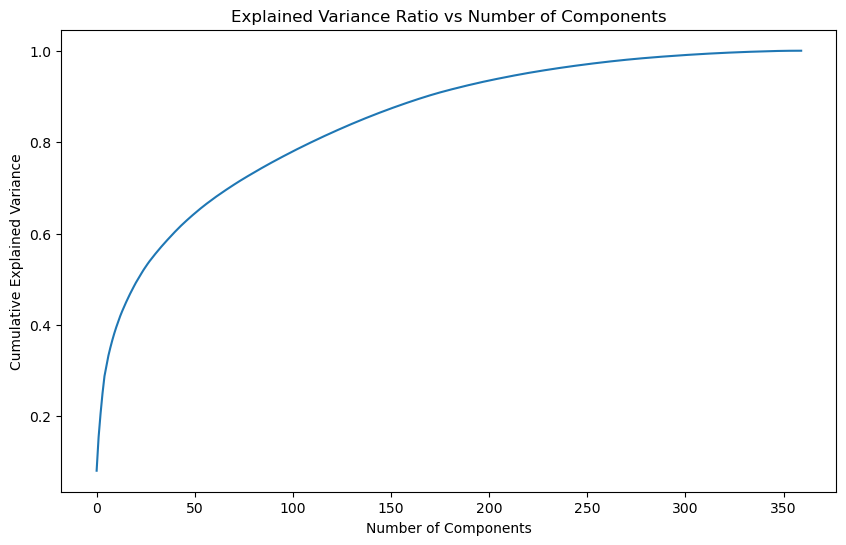

In [48]:
from sklearn.decomposition import PCA

pca = PCA()  # We will determine the number of components based on the explained variance ratio
azdias_pca = pca.fit_transform(azdias_scaled)
customers_pca = pca.transform(customers_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio vs Number of Components')
plt.show()


In [49]:
pca = PCA(n_components=100)
azdias_pca = pca.fit_transform(azdias_scaled)
customers_pca = pca.transform(customers_scaled)


In [50]:
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the elbow method or silhouette scores
# ...

k = 5  # Replace with the optimal number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
azdias_clusters = kmeans.fit_predict(azdias_pca)
customers_clusters = kmeans.predict(customers_pca)


In [51]:
def cluster_proportions(labels, n_clusters):
    count = np.bincount(labels)
    return count / len(labels)

azdias_proportions = cluster_proportions(azdias_clusters, k)
customers_proportions = cluster_proportions(customers_clusters, k)

print("Proportions for the general population:", azdias_proportions)
print("Proportions for the customers:", customers_proportions)


Proportions for the general population: [0.29584806 0.24946001 0.09514251 0.3429587  0.01659072]
Proportions for the customers: [0.09581429 0.33488302 0.24369169 0.3207428  0.0048682 ]


In [52]:
over_represented = customers_proportions - azdias_proportions
print("Over-represented clusters:", np.argsort(over_represented)[-3:][::-1])  # Top 3 over-represented clusters

under_represented = azdias_proportions - customers_proportions
print("Under-represented clusters:", np.argsort(under_represented)[-3:][::-1])  # Top 3 under-represented clusters


Over-represented clusters: [2 1 4]
Under-represented clusters: [0 3 4]


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [56]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', delimiter=';')
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', delimiter=';')

mailout_train_clean = preprocess_data(mailout_train, drop_cols=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'])
mailout_test_clean = preprocess_data(mailout_test, drop_cols=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'])


In [57]:
X_train = mailout_train_clean.drop('RESPONSE', axis=1)
y_train = mailout_train_clean['RESPONSE']
X_test = mailout_test_clean

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   2.9s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   2.9s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   3.3s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   5.9s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   5.9s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   6.0s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END ..max_depth=5, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END ..max_depth=5, min_samples_split=5, n_

In [59]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_scaled, y_train)


RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

In [60]:
from sklearn.metrics import roc_auc_score

y_train_pred = best_rf.predict_proba(X_train_scaled)[:, 1]
roc_auc = roc_auc_score(y_train, y_train_pred)
print("ROC-AUC score:", roc_auc)


ROC-AUC score: 0.9033607321390915


In [62]:
y_test_pred = best_rf.predict_proba(X_test_scaled)[:, 1]
